Récupération et exploration du corpus d'un texte
--------------------------

Il est important de bien identifier 4 termes incontournables : 

- le corpus : un ensemble de documents (des textes dans notre cas), regroupés dans une optique ou dans une thématique précise. 

- un document : la notion de document fait référence à un texte appartenant au corpus, mais indépendant des autres textes. Il peut être constitué d'une ou plusieurs phrases, un ou plusieurs paragraphes.

- un token : le terme token désigne généralement un mot et/ou un élément de ponctuation. La phrase "Hello World!" comprend donc 3 tokens. 

- le vocabulaire : il s'agit de l'ensemble des tokens distincts présents dans l'ensemble du corpus.

Pour les documents .txt, .doc, .csv, .xls, cela semble facile, mais comment faire pour les documents .pdf ?  

Transformer les documents .pdf en .txt n'est pas une chose facile. Ce traitement spécifique à un nom, cela s'appelle OCR :  Optical Character Recognition. 

Heureusement, il existe de nombreux packages disponibles, comme par exemple Tesseract.

Nous allons aborder trois pré-traitements à effectuer:
- Récupération et traitement du corpus
- La tokénisation du corpus
- La normalisation et la construction du dictionnaire

Le cycle de traitement d'un corpus

![pipeline](pipeline1.png)

### Récupération du corpus de texte

Attention au format d'encodage de vos fichiers texte qui peuvent mener à des erreurs faciles à éviter. On favorisera l'UTF-8 (encodage universel) très utilisé et qui permet l'usage des accents.

![corpus_structure](text-corpus-structure.png)

In [9]:
import nltk

In [10]:
nltk.corpus.brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [11]:
# prenons science_fiction et humor
words = nltk.corpus.brown.words(categories=['humor', 'science_fiction'])

In [12]:
len(words)

36165

Scraping des descriptions des artistes francais disponible sur wikipedia https://fr.wikipedia.org/wiki/Liste_d%27artistes_fran%C3%A7ais

In [45]:
import requests as rq
from bs4 import BeautifulSoup
from tqdm import tqdm
import pickle
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

C:\Users\Oumar Kane\AppData\Local\Temp\ipykernel_10552\3563997442.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [14]:
url = r"https://fr.wikipedia.org/wiki/Liste_d%27artistes_fran%C3%A7ais"


with rq.get(url) as response:
    if response.ok:
        text = response.text
        
        artistes = {}
        
        try:
            dom = BeautifulSoup(text, "lxml")
            artistes_li = dom.select('div[id = "mw-content-text"] li a[href *= "/wiki"]')
            
            # après récupération des listes nous pouvons passer à celles des noms et des descriptions
            
            for artiste in tqdm(artistes_li):
                # recuperation du nom
                name = artiste.text
                
                # recuperation de la description a partir du lien wikipedia
                link = artiste.get('href')
                
                full_link = "".join(["https://fr.wikipedia.org/", link])
                
                descriptions = []
                
                with rq.get(full_link) as response2:
                    
                    if response2.ok:
                        
                        text2 = response2.text
                    
                        try:
                            dom2 = BeautifulSoup(text2, "lxml")

                            paragraphs = dom2.select('p')
                        
                            for paragraph in paragraphs:
                                p_text = paragraph.text
                                descriptions.append(p_text)
                                
                            
                        except Exception as e:
                            print(f"Error part 2 {e}")
                
                if len(descriptions) != 0:
                     artistes[name] = "".join(descriptions)
                
        except Exception as e:
            print(f"Error {e}")

100%|██████████| 399/399 [05:35<00:00,  1.19it/s]


Quelques textes ne faisant pas partie des descriptions des artistes reviennent fréquemment. Nous avons ci-dessus décider de les supprimer directement.

In [15]:
list(artistes.items())[:2]

[('Jean Pucelle',
  "\n\t\t\t\tPages pour les contributeurs déconnectés en savoir plus\nPour les articles homonymes, voir Pucelle.\nmodifier - modifier le code - modifier WikidataJean Pucelle (mort en 1334) est un enlumineur français, actif à Paris entre 1319 et 1334.\nSon nom apparaît dans plusieurs documents d'archives et deux manuscrits enluminés. Quelques autres ouvrages lui sont attribués, en personne ou à son atelier. Empreint d'influence italienne, son art influence durablement l'enluminure parisienne tout au long du XIVe\xa0siècle.\nLe peintre et enlumineur est mentionné pour la première fois, entre 1319 et 1324, dans les comptes de la confrérie parisienne de Saint-Jacques-aux-Pèlerins. Chargé d'en dessiner le sceau, il est rémunéré à ce titre[1].\nSelon certains historiens de l'art, il aurait effectué vers 1322 un voyage en Toscane, et notamment à Sienne[2]. \nDeux manuscrits contiennent des mentions établissant la participation de Jean Pucelle. Le Bréviaire de Belleville, réa

Vérification du nombre d'artistes.

In [16]:
len(artistes)

383

### Exploration du text: tokenisation et analyse des fréquences

In [17]:
text = "Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !"

nltk.word_tokenize(text)

['Bonjour',
 ',',
 'je',
 'suis',
 'un',
 'texte',
 "d'exemple",
 'pour',
 'le',
 'cours',
 "d'Openclassrooms",
 '.',
 'Soyez',
 'attentifs',
 'à',
 'ce',
 'cours',
 '!']

Les accents sont affichés encodés mais ce n'est pas très grave, on peut revenir à un affichage normal si on le souhaite.

Le fait d'essayer d'harmoniser les tokens est un processus nommé « normalisation ». 

https://www.debuggex.com/cheatsheet/regex/python

In [18]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

tokenizer.tokenize(text)

['Bonjour',
 'je',
 'suis',
 'un',
 'texte',
 'd',
 'exemple',
 'pour',
 'le',
 'cours',
 'd',
 'Openclassrooms',
 'Soyez',
 'attentifs',
 'à',
 'ce',
 'cours']

In [29]:
from nltk.corpus import stopwords

In [33]:
stopwords = stopwords.words("french")

Explorons les fréquences de mots utilisés pour la description de chaque artiste suivant les artistes.

In [34]:
def get_frequency(dictionary: dict, regex: str = r"\w+", to_remove: list = [r"\n\t\t\t\tPages pour les contributeurs déconnectés en savoir plus\n", r"modifier - modifier le code - modifier Wikidata", r"\nSur les autres projets Wikimedia\xa0:"]):
    
    # Nous voulons eviter les stopwords en francais donc nous allons les enlever
    
    # Creation du tokenizer
    tokenizer = nltk.RegexpTokenizer(regex)
    
    # Appliquons d'abord quelques normalisations du text
    corpora = {}
    for key, value in dictionary.items():
        # application du regex et transformation en miniscules des lettres
        for t in to_remove:
            value = value.replace(t, "")
        corpora[key] = [word for word in tokenizer.tokenize(value.lower()) if word not in stopwords]
    
    freq, stats = dict(), dict()
    for key, value in corpora.items():
        freq[key] = fq = nltk.FreqDist(value)
        stats[key] = {"total": len(value), "unique": len(fq.keys())}
    
    return freq, stats, corpora

Sauvegardons les données recueillies du webscraping.

In [35]:
with open("artistes.txt", "wb") as f:
    pick = pickle.Pickler(f)
    pick.dump(artistes)

Tracons les fréquences à l'aide d'un dataframe pandas

In [36]:
freq, stats, corpora = get_frequency(artistes)

In [38]:
df = pd.DataFrame.from_dict(stats, orient="index")

In [39]:
df.head()

,total,unique
Jean Pucelle,220,175
Claus Sluter,782,472
Bourgogne,1418,804
Les frères de Limbourg,1080,652
Antoine Le Moiturier,290,211


Prenons le top 30

In [40]:
df_sorted = df.sort_values('total', ascending=False)

In [41]:
df_top = df_sorted.head(30)

In [42]:
df_top

,total,unique
Charles Le Brun,18774,5516
Albert Marquet,11073,4332
Pierre Bonnard,10882,4361
Chaïm Soutine,10479,4427
Édouard Manet,10100,3673
Jacques Louis David,9889,3861
Hyacinthe Rigaud,8582,3443
Gustave Courbet,8309,3555
Gustave Moreau,8091,3246
Georges Braque,7382,2795


<AxesSubplot: title={'center': 'Top 30 des artistes avec le plus de mots utilisés'}>

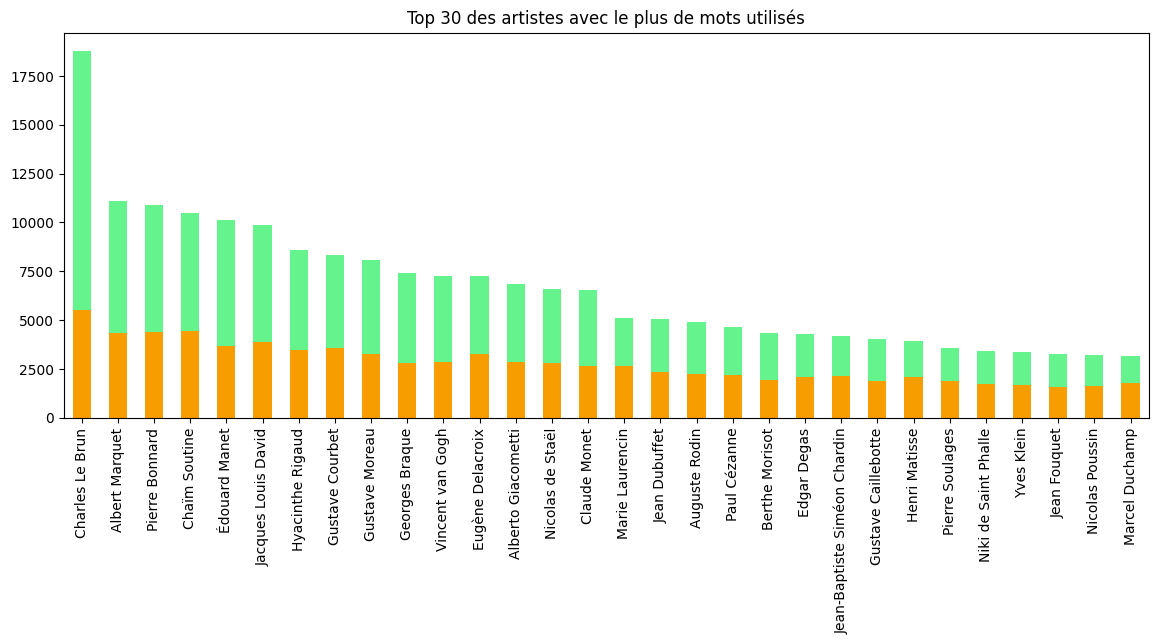

In [51]:
plt.figure(figsize=(14, 5))
ax = df_top['total'].plot(kind="bar", color = "#64f38c", title="Top 30 des artistes avec le plus de mots utilisés")
df_top['unique'].plot(kind="bar", color = "#f79d00", ax = ax)